# Capstone Project - Starbucks
## 1. Pre-processing

Feature Engineering is the process of determining which features might be useful in training a model, and then converting raw data from log files and other sources into said features.

In [81]:
import pandas as pd
import numpy as np
import math
import json
import boto3
import sagemaker
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
%matplotlib inline

### Load the data

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## portfolio


### Overview

In [4]:
print("Shape of portfolio: " + str(portfolio.shape))
print("")
portfolio

Shape of portfolio: (10, 6)



,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## profile


### Overview

In [5]:
print("Shape of profile: " + str(profile.shape))
print("")
profile

Shape of profile: (17000, 5)



,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


### Transformation

Index the profile data using id feature. 

This will help later in joining it with portfolio and transcript to enrich the data.

In [6]:
# make profile id the index
profile_id_as_index = profile.copy()
profile_id_as_index.set_index('id', inplace=True)


### Resultant dataset

In [7]:
profile_id_as_index

,gender,age,became_member_on,income
id,,,,
68be06ca386d4c31939f3a4f0e3dd783,None,118,20170212,NaN
0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.0
38fe809add3b4fcf9315a9694bb96ff5,None,118,20180712,NaN
78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0
a03223e636434f42ac4c3df47e8bac43,None,118,20170804,NaN
...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45,20180604,54000.0
2cb4f97358b841b9a9773a7aa05a9d77,M,61,20180713,72000.0
01d26f638c274aa0b965d24cefe3183f,M,49,20170126,73000.0


## transcript

### Overview

In [8]:
print("Shape of transcript: " + str(transcript.shape))
print("")
transcript

Shape of transcript: (306534, 4)



,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### Transformation

#### Filter out the customer who have completed the offers. 

This is important as we are intersted in customers completing their offers.

In [9]:
# Filter out the customer who have completed the offers.
completed_offers = transcript[transcript['event'] == 'offer completed'].copy()


Add a new column offer_id. 

This extracts the value from the key:value parin in the feater called 'value'. As in current form its unusable.

In [10]:
completed_offers['offer_id'] = completed_offers.apply(lambda row: row.value['offer_id'], axis=1)
completed_offers

,person,event,value,time,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4


#### Filter out the customer who have viewed the offers.

This is needed as we will be joining it with the the customer who have completed the offers.

In [11]:
# Filer out all the customers who have viewed the offer.
viewed_offers_df = transcript[transcript['event'] == 'offer viewed'].iloc[0:1000].copy()
viewed_offers_df

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
...,...,...,...,...
14048,7f370edef8ae471bb1e3067f84f5a9d0,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
14049,a9c89c0882154db68a99adcf81eac27e,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
14050,798d915dfb6a4477adf06802ba29477e,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
14051,e4c38c75c12f4bec9fb35546b14c5fd5,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0


#### Finding customer who have viewed and also complted the offers.

Below methods tabkes the:
    * person_id
    * offer_id
    * cpmplted_offers data

    Returns: dataframe with customer who have viewed offers and also complted them.

In [12]:
# method will find out all the cutomers whoi have completed the offers.
def is_offer_used(person_id, offer_id, completed_offers):
    offer_used = completed_offers[(completed_offers['person'] == person_id) & (completed_offers['offer_id'] == offer_id)]
    return int(not offer_used.empty)

Using method 'is_offer_used', create 'offer_used_label'. 

* Label 1: Customers who have viewed and completed the offers.
* Label 0: Customer who have only viewed the offers but never completed them.

In [13]:
# Label 1 if a customer view the offer and also completed the offer.
# Label 0 if a customer view the offer but did not complete the offer.
viewed_offers_df['offer_used_label'] = viewed_offers_df.apply(lambda row: is_offer_used(row['person'], row['value']['offer id'], completed_offers), axis=1)
viewed_offers_df

,person,event,value,time,offer_used_label
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,1
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0
...,...,...,...,...,...
14048,7f370edef8ae471bb1e3067f84f5a9d0,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
14049,a9c89c0882154db68a99adcf81eac27e,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
14050,798d915dfb6a4477adf06802ba29477e,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,1
14051,e4c38c75c12f4bec9fb35546b14c5fd5,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1


#### Analysis 

Total offers viewed but not completed.

Total count:                    502

In [14]:
# total offers viewed but not completed
viewed_offers_df[viewed_offers_df['offer_used_label'] == 0].count()

person              502
event               502
value               502
time                502
offer_used_label    502
dtype: int64

Total offers viewed and completed.

Total count: 498

In [15]:
# total offers viewed and completed
viewed_offers_df[viewed_offers_df['offer_used_label'] == 1].count()

# From above 2 cells we find that data set is balanced as 
# count for label 0 = 28269
# count for label 1 = 29456

person              498
event               498
value               498
time                498
offer_used_label    498
dtype: int64

#### Create valid offers data

Create a new dataframe and enrigh it with more infomration.

Done by joining 'profile_id_as_index' and 'viewed_offer' dataframes.

In [16]:
# create valid offers and enrich with extra info.
valid_offers_df = pd.DataFrame(columns=['age', 'became_member_on', 'gender', 'income', 'event', 'person', 'time', 'value', 'offer_used_label'])
for idx, viewed_offer in viewed_offers_df.iterrows():
    valid_offers_df.loc[idx] = profile_id_as_index.loc[viewed_offer['person']].append(viewed_offer)
valid_offers_df

,age,became_member_on,gender,income,event,person,time,value,offer_used_label
12650,65,20180209,M,53000.0,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},1
12651,53,20170916,O,52000.0,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,69,20160814,F,57000.0,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1
12653,20,20160711,F,30000.0,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,39,20140527,M,51000.0,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
...,...,...,...,...,...,...,...,...,...
14048,53,20141201,M,100000.0,offer viewed,7f370edef8ae471bb1e3067f84f5a9d0,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
14049,118,20180501,None,NaN,offer viewed,a9c89c0882154db68a99adcf81eac27e,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
14050,78,20131229,M,57000.0,offer viewed,798d915dfb6a4477adf06802ba29477e,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},1
14051,64,20170703,M,98000.0,offer viewed,e4c38c75c12f4bec9fb35546b14c5fd5,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1


#### cleaning

Fill the income values with 0 if it contains null.

In [17]:
# fill 0 for income where its not available
valid_offers_df['income'].fillna(0, inplace=True)
valid_offers_df.count()

age                 1000
became_member_on    1000
gender               840
income              1000
event               1000
person              1000
time                1000
value               1000
offer_used_label    1000
dtype: int64

Temporarily drop non-converted features

To train out model we are going to use only 'age', 'time' and 'offer_used_label'.

In [18]:
# Temporarily drop non-converted features
valid_offers_df.drop(['became_member_on', 'gender', 'event', 'person', 'value'], axis=1, inplace=True)
valid_offers_df

,age,income,time,offer_used_label
12650,65,53000.0,0,1
12651,53,52000.0,0,0
12652,69,57000.0,0,1
12653,20,30000.0,0,0
12655,39,51000.0,0,0
...,...,...,...,...
14048,53,100000.0,0,0
14049,118,0.0,0,0
14050,78,57000.0,0,1
14051,64,98000.0,0,1


### Create Training and testing data

In [19]:
# Split data into labels and features
#valid_offers_used = valid_offers_df['offer_used_label'].copy()
valid_offers_used_label = valid_offers_df['offer_used_label'].copy()
valid_offers_used_features = valid_offers_df.drop(['offer_used_label'], axis=1)


#### Split training and testing data in 80 to 20 ration respectively

In [20]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(valid_offers_used_features, 
                                                    valid_offers_used_label, 
                                                    test_size = 0.2, 
                                                    random_state = 0)


#### Verification of train and test data

In [21]:
print("Training features and it's count: " + str(X_train.count()['time']))
print("")
X_train


Training features and it's count: 800



,age,income,time
13593,20,66000.0,0
13318,30,55000.0,0
13094,53,74000.0,0
14027,42,89000.0,0
13774,42,71000.0,0
...,...,...,...
13800,77,83000.0,0
12909,33,42000.0,0
13499,57,91000.0,0
13399,53,67000.0,0


In [22]:
print("Training lables and it's count: " + str(y_train.count()))
print("")
y_train


Training lables and it's count: 800



13593    1
13318    0
13094    1
14027    0
13774    1
        ..
13800    1
12909    0
13499    1
13399    0
13588    1
Name: offer_used_label, Length: 800, dtype: object

In [23]:
print("Test features and it's count: " + str(X_test.count()['time']))
print("")
X_test.head()


Test features and it's count: 200



,age,income,time
14044,118,0.0,0
13843,42,54000.0,0
13051,51,90000.0,0
13391,66,73000.0,0
13567,52,41000.0,0


In [24]:
print("Test labels and it's count: " + str(y_test.count()))
print("")
y_test.head()


Test labels and it's count: 200



14044    0
13843    1
13051    0
13391    1
13567    0
Name: offer_used_label, dtype: object

#### Write training data to a csv

In [25]:
import os

def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # combine labels and features 
    pd.concat([y, x], axis=1)\
        .to_csv(os.path.join(data_dir, filename), header=False, index=False)
    
    # indicate function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

Write training data in data_starbucks/train.csv

In [26]:
data_dir = 'data_starbucks' # the folder I will use for storing data in notebook
name = 'train.csv'

# create 'train.csv'
make_csv(X_train, y_train, name, data_dir)

Path created: data_starbucks/train.csv


## 2. Model training

### Upload training data to S3

Create Sagemaker session and get its role.

In [29]:
# upload data to s3
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
role

'arn:aws:iam::186768347586:role/service-role/AmazonSageMaker-ExecutionRole-20200514T122821'

#### Get the S3 bucket

In [30]:
# create an S3 bucket
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-eu-north-1-186768347586'

#### upload the training data

In [31]:
# directory for features data
data_dir = 'data_starbucks'

# prefix: description name for directory in S3
prefix = 'starbucks-capstone/offer-data'

# upload all data to S3
uploaded_data_s3 = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(uploaded_data_s3)

s3://sagemaker-eu-north-1-186768347586/starbucks-capstone/offer-data


#### Test if data is in S3 bucket

In [32]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

sagemaker-pytorch-2021-04-11-09-15-09-542/source/sourcedir.tar.gz
sagemaker-pytorch-2021-04-11-09-15-34-989/source/sourcedir.tar.gz
sagemaker-pytorch-2021-04-11-09-21-20-383/sourcedir.tar.gz
sagemaker-pytorch-2021-04-11-09-21-20-571/sourcedir.tar.gz
sagemaker-pytorch-2021-04-11-10-24-44-299/source/sourcedir.tar.gz
sagemaker-pytorch-2021-04-11-10-33-00-692/sourcedir.tar.gz
sagemaker-scikit-learn-2021-04-11-08-22-07-540/profiler-output/system/incremental/2021041108/1618129440.algo-1.json
sagemaker-scikit-learn-2021-04-11-08-22-07-540/source/sourcedir.tar.gz
sagemaker-scikit-learn-2021-04-11-08-35-46-311/profiler-output/system/incremental/2021041108/1618130220.algo-1.json
sagemaker-scikit-learn-2021-04-11-08-35-46-311/profiler-output/system/incremental/2021041108/1618130280.algo-1.json
sagemaker-scikit-learn-2021-04-11-08-35-46-311/rule-output/ProfilerReport-1618130146/profiler-output/profiler-report.html
sagemaker-scikit-learn-2021-04-11-08-35-46-311/rule-output/ProfilerReport-1618130146

## Model 1: Linear SVC from sklearn

Load the training code

In [33]:
!pygmentize source_sklearn/train.py

from __future__ import print_function

import argparse
import os
import pandas as pd

# sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. 
# from sklearn.externals import joblib
# Import joblib package directly
import joblib

## TODO: Import any additional libraries you need to define a model
from sklearn.svm import LinearSVC


# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


## TODO: Complete the main code
if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the parameters
    parser = argp

### Create Estimator object

In [34]:
# Define and train model
from sagemaker.sklearn.estimator import SKLearn

estimator = SKLearn(entry_point='train.py',
                    source_dir='/home/ec2-user/SageMaker/Capstone-Starbucks-Project/source_sklearn',
                    role=role,
                    py_version="py3",
                    framework_version='0.23-1',
                    train_instance_count=1,
                    train_instance_type='ml.m5.large')

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Train Linear SVC model

In [35]:
%time
# Train estimator on S3 training data
estimator.fit({'train': uploaded_data_s3})

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
2021-04-14 12:23:35 Starting - Starting the training job...
2021-04-14 12:23:37 Starting - Launching requested ML instancesProfilerReport-1618403015: InProgress
......
2021-04-14 12:25:00 Starting - Preparing the instances for training.........
2021-04-14 12:26:33 Downloading - Downloading input data...
2021-04-14 12:26:54 Training - Downloading the training image2021-04-14 12:26:55,448 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-04-14 12:26:55,450 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-04-14 12:26:55,459 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-04-14 12:26:55,755 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-04-14 12:26:55,767 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-04-14 12:26:55,778 sagemaker-trai

### Deploy the model to an Endpoint

In [36]:
%%time

# deploy model to create a predictor
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-------------!CPU times: user 189 ms, sys: 23.3 ms, total: 213 ms
Wall time: 6min 31s


### Get predicted labels using test features

In [38]:
# Determine accuracy of model
# First: generate predicted, class labels
test_y_preds = predictor.predict(X_test)
test_y_preds

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0])

#### Test if size of prediction label is equal to original test labels

In [39]:
# test that model generates the correct number of labels
assert len(test_y_preds)==len(y_test), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


In [42]:
test_y = pd.DataFrame(y_test).iloc[:,0]
converted_test_y = test_y.reset_index(drop=True).values.astype(int)
converted_test_y

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0])

### Check Accuracy

In [43]:
from sklearn.metrics import accuracy_score

# Second: calculate the test accuracy
accuracy = accuracy_score(converted_test_y, test_y_preds.round())

### Linear SVC accuracy : 0.625

In [203]:
print(accuracy)

## print out the array of predicted and true labels, if you want
print('\nPredicted class labels: ')
print(test_y_preds)
print('\nTrue class labels: ')
print(test_y.values)

0.625

Predicted class labels: 
[0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]

True class labels: 
[0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0
 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 1
 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0
 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1
 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0]


### Linear SVC precision : 0.56

In [93]:
# Compute the average precision score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
linearSVC_precision = average_precision_score(test_y.astype('int'), test_y_preds.astype('int'))

print('linearSVC precision score: {0:0.2f}'.format(
      average_precision))

linearSVC precision score: 0.56


### Linear SVC recall : 0.94

In [94]:
from sklearn.metrics import average_precision_score
linearSVC_recall = recall_score(test_y.astype('int'), test_y_preds.astype('int'))
print('linearSVC recall score: {0:0.2f}'.format(
      recall)) 

linearSVC recall score: 0.94


### Confusion matrix : Linear SVC

In [165]:
def build_cmatrix(c_matrix, ax):
    ax.matshow(c_matrix, cmap='YlGn')
    ax.set_xlabel('Confusion Matrix')
    ax.text(0, 0, f'TN\n{c_matrix[0,0]}',
            ha="center", va="center", color="k")
    ax.text(0, 1, f'FN\n{c_matrix[1,0]}',
            ha="center", va="center", color="k")
    ax.text(1, 0, f'FP\n{c_matrix[0,1]}',
            ha="center", va="center", color="w")
    ax.text(1, 1, f'TP\n{c_matrix[1,1]}',
            ha="center", va="center", color="w")

[[35 69]
 [ 6 90]]


Text(0.5, 1.0, 'sklearn linearSVC\n')

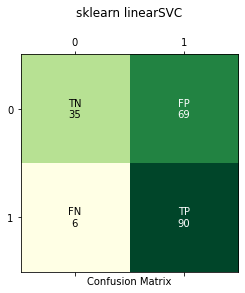

In [166]:
import sklearn.metrics as metrics
c_matrix = metrics.confusion_matrix(test_y.astype('int'), test_y_preds.astype('int'))

print(c_matrix)

# Build the confusion matrix
fig, axs = plt.subplots(nrows=1, ncols=1)

build_cmatrix(c_matrix, axs)
axs.set_title('sklearn linearSVC\n')

### Normalized confusion matrix: Linear SVC

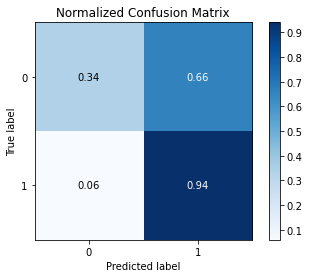

In [149]:
# Normalized
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(test_y.astype('int'), test_y_preds.astype('int'), normalize=True)
plt.show()

In [144]:
pip install scikit-plot

  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
Note: you may need to restart the kernel to use updated packages.


## Model 2:  PyTorch - Feed Forward Neural Network

In [150]:
#PyTorch: Feed Forward Neural Network 
!pygmentize source_pytorch/train.py

import argparse
import json
import os
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from model import BinaryClassifier

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # Load the parameters used to create the model
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BinaryClassifier(model_info['input_features'], model_info['hidden_dim'], model_info['output_dim'])

    # Load the stored model parameters
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
        model.load_state_dict(torch.load(f))

    # Set to eval mode,

## Create PyTorch Estimator

In [152]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='source_pytorch',
                    role=role,
                    py_version="py3",
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.m5.large',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'input_features': 3, # number of features
                        'hidden_dim': 2,
                        'output_dim': 1,
                        'epochs': 80
                    })

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Train neural network model

In [153]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': uploaded_data_s3})

2021-04-14 16:29:28 Starting - Starting the training job...
2021-04-14 16:29:30 Starting - Launching requested ML instancesProfilerReport-1618417768: InProgress
......
2021-04-14 16:30:35 Starting - Preparing the instances for training......
2021-04-14 16:31:56 Downloading - Downloading input data
2021-04-14 16:31:56 Training - Downloading the training image...
2021-04-14 16:32:27 Uploading - Uploading generated training modelbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-04-14 16:32:12,968 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-04-14 16:32:12,971 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-04-14 16:32:12,982 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-04-14 16:32:12,983 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-04-14 16:32:13,206 sagemaker-

## Instantiate a PyTorchModel

In [154]:
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role=role,
                     py_version="py3",
                     framework_version='1.0',
                     entry_point='predict.py',
                     source_dir='source_pytorch')

## Deploy Model

In [155]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-------------!CPU times: user 289 ms, sys: 10.7 ms, total: 300 ms
Wall time: 6min 32s


In [169]:
# Convert test data
X_test_converted = X_test.reset_index(drop=True).values.astype(int)
y_test_converted = test_y.reset_index(drop=True).values.astype(int)


In [159]:
# Evaluate the model
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # rounding and squeezing array
    test_preds = np.squeeze(np.round(predictor.predict(test_features)))
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

### Predicted and true labels

In [177]:
test_preds = np.squeeze(np.round(predictor.predict(X_test_converted)))

## print out the array of predicted and true labels, if you want
print('\nPredicted class labels: ')
print(test_preds.astype('int'))
print('\nTrue class labels: ')
print(test_y.values)


Predicted class labels: 
[0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]

True class labels: 
[0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0
 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 1
 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0
 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1
 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0]


### Get metrics for custom predictor

In [178]:
# get metrics for custom predictor
metrics = evaluate(predictor, X_test_converted, y_test_converted, True)

predictions  0.0  1.0
actuals              
0             33   71
1              4   92

Recall:     0.958
Precision:  0.564
Accuracy:   0.625



### Confusion matrix : Feed Forward Neural Network

[[33 71]
 [ 4 92]]


Text(0.5, 1.0, 'Feed Forward Neural Network\n')

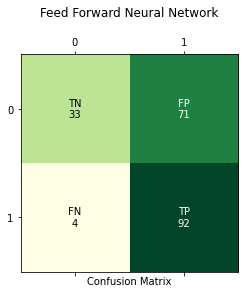

In [179]:
import sklearn.metrics as metrics
c_matrix = metrics.confusion_matrix(test_y.astype('int'), test_preds.astype('int'))

print(c_matrix)

# Build the confusion matrix
fig1, axs1 = plt.subplots(nrows=1, ncols=1)

build_cmatrix(c_matrix, axs1)
axs1.set_title('Feed Forward Neural Network\n')

### Normalized Confusion matrix : Feed Forward Neural Network

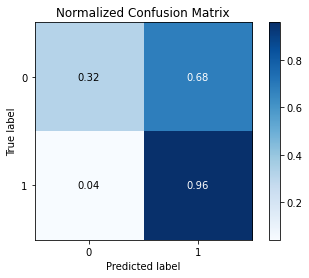

In [180]:
# Normalized
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(test_y.astype('int'), test_preds.astype('int'), normalize=True)
plt.show()

## Compare : Linear SVC and Feed Forward Neural Netwrok


In [196]:
# Comparison

# Table of results
result_df = pd.DataFrame(
    [[f'{0.625*100:.2f}%', 0.564, 0.958],
     [f'{0.625*100:.2f}%', 0.56, 0.94]],
    columns=['accuracy (%)', 'precision', 'recall'],
    index=['Linear Classifier',
         'Recurrent Classifier']).T

result_df

,Linear Classifier,Recurrent Classifier
accuracy (%),62.50%,62.50%
precision,0.564,0.56
recall,0.958,0.94


### Compare Confusion Matrix between two models

Feed Forward Neral Network
[[33 71]
 [ 4 92]]

Linear SVC
[[35 69]
 [ 6 90]]


Text(0.5, 1.0, 'Linear SVE\n')

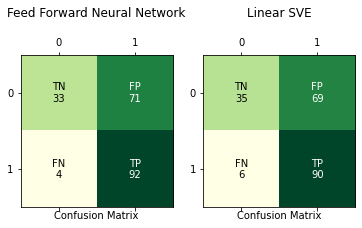

In [191]:
# Comparison

fig, axs = plt.subplots(nrows=1, ncols=2)

# Feed Forward Neral Network
feed_forward_nuralNetwork_matrix = metrics.confusion_matrix(test_y.astype('int'), test_preds.astype('int'))
print("Feed Forward Neral Network")
print(feed_forward_nuralNetwork_matrix); print("")
# Build the confusion matrix
build_cmatrix(feed_forward_nuralNetwork_matrix, axs[0])
axs[0].set_title('Feed Forward Neural Network\n')


# LinearSVC from sklearn
sklearn_linearSVC_matrix = metrics.confusion_matrix(test_y.astype('int'), test_y_preds.astype('int'))
print("Linear SVC")
print(sklearn_linearSVC_matrix)
# Build the confusion matrix
build_cmatrix(sklearn_linearSVC_matrix, axs[1])
axs[1].set_title('Linear SVE\n')

## Delete Endpoints

In [ ]:
# Accepts a predictor endpoint as input
# And deletes the endpoint by name
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [ ]:
# delete the predictor endpoint 
delete_endpoint(predictor)